In [2]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langchain.chat_models import ChatOpenAI
from langchain.tools import tool
import requests
from bs4 import BeautifulSoup
import json
import os

In [ ]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model


ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002A4B279B350>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002A4B274EE70>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [30]:
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
llm=init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002A4B290CE90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002A4B290E7B0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [31]:
from langchain_tavily import TavilySearch

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [36]:
from langchain_community.tools.tavily_search import TavilySearchResults

search_tool = TavilySearchResults(k=5)

C:\Users\Ritika.Sardar\AppData\Local\Temp\ipykernel_6700\283652598.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(k=5)


In [37]:


def search_node(state: dict):
    keyword = state.get("product")
    if not keyword:
        raise ValueError("Missing 'product' in state")
    
    results = search_tool.invoke({"query": f"{keyword} product blog news"})
    links_text = "\n".join([res["content"] for res in results])
    return {**state, "search_results": links_text}



def summarize_node(state: dict):
    summary = llm.invoke(f"Summarize this in 5 bullets:\n{state['search_results']}").content
    return {**state, "summary": summary}

def strategy_node(state: dict):
    prompt = f"Based on this:\n{state['summary']}\nSuggest 3 go-to-market strategies."
    strategies = llm.invoke(prompt).content
    return {**state, "strategies": strategies}

def save_node(state: dict):
    filename = f"{state['product'].replace(' ', '_')}_report.json"
    with open(filename, "w") as f:
        json.dump({
            "product": state["product"],
            "summary": state["summary"],
            "strategies": state["strategies"]
        }, f, indent=2)
    return {**state, "file": filename}


In [ ]:
# Build LangGraph
builder = StateGraph(dict)

builder.add_node("Search", search_node)
builder.add_node("Summarize", summarize_node)
builder.add_node("Strategy", strategy_node)
builder.add_node("Save", save_node)

builder.set_entry_point("Search")
builder.add_edge("Search", "Summarize")
builder.add_edge("Summarize", "Strategy")
builder.add_edge("Strategy", "Save")
builder.add_edge("Save", END)

graph = builder.compile()

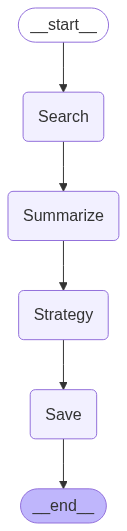

In [39]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
initial_state = {"product": "electric toothbrush"}
final_state = graph.invoke(initial_state)